<a href="https://colab.research.google.com/github/NeerajVeerla/CVworkshop/blob/master/Day4/cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using CNNs and ResNets in PyTorch

In the previous tutorial, we trained a feedfoward neural networks with a single hidden layer to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist) with over 97% accuracy. For this tutorial, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">


## Exploring the Data

We'll download the images in PNG format from [this page](http://files.fast.ai/data), using some helper functions from the `torchvision` and `tarfile` packages.

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [51]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

  0%|          | 0/169168619 [00:00<?, ?it/s]

In [52]:
# Extract from archive
with tarfile.open('/content/cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory `data/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [53]:
data_dir = './data/cifar100'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['small_mammals', 'non-insect_invertebrates', 'large_omnivores_and_herbivores', 'fish', 'food_containers', 'aquatic_mammals', 'reptiles', 'fruit_and_vegetables', 'insects', 'flowers', 'medium_mammals', 'people', 'trees', 'large_natural_outdoor_scenes', 'vehicles_1', 'household_electrical_devices', 'large_carnivores', 'large_man-made_outdoor_things', 'vehicles_2', 'household_furniture']


Let's look inside a couple of folders, one from the training set and another from the test set. As an exercise, you can verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [58]:
airplane_files = os.listdir(data_dir + "/train/flowers")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5
['orchid', 'tulip', 'poppy', 'sunflower', 'rose']


In [56]:
ship_test_files = os.listdir(data_dir + "/test/fish")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 5
['trout', 'ray', 'shark', 'aquarium_fish', 'flatfish']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [59]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [60]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

In [61]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.6196, 0.6431, 0.6392,  ..., 0.5843, 0.5451, 0.4941],
         [0.6039, 0.6353, 0.6353,  ..., 0.5843, 0.5490, 0.4980],
         [0.6078, 0.6431, 0.6431,  ..., 0.5804, 0.5490, 0.5020],
         ...,
         [0.7059, 0.7216, 0.6863,  ..., 0.8549, 0.8471, 0.7961],
         [0.8902, 0.8667, 0.7804,  ..., 0.9569, 0.9647, 0.9451],
         [0.9804, 0.9647, 0.9098,  ..., 0.9843, 0.9843, 0.9451]],

        [[0.6314, 0.6745, 0.6863,  ..., 0.5804, 0.5490, 0.5137],
         [0.6275, 0.6824, 0.6902,  ..., 0.5922, 0.5647, 0.5294],
         [0.6353, 0.6902, 0.6980,  ..., 0.5961, 0.5765, 0.5333],
         ...,
         [0.7608, 0.7804, 0.7490,  ..., 0.8745, 0.8706, 0.8196],
         [0.9216, 0.9059, 0.8275,  ..., 0.9725, 0.9765, 0.9647],
         [0.9922, 0.9804, 0.9333,  ..., 0.9922, 0.9922, 0.9608]],

        [[0.3922, 0.3843, 0.3765,  ..., 0.3725, 0.3451, 0.3255],
         [0.3843, 0.3843, 0.3765,  ..., 0.3725, 0.3529, 0.3294],
         [0.3765, 0.3843, 0.3765,  ..., 0.3765, 0.3686, 0.

The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [62]:
print(dataset.classes)

['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(32,32,3)`. Let's create a helper function to display an image and its label.

In [64]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset. As you can tell, the 32x32px images are quite difficult to identify, even for the human eye. Try changing the indices below to view different images.

Label:  aquatic_mammals (0)


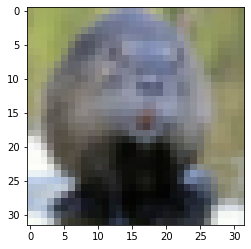

In [65]:
show_example(*dataset[0])

Label:  aquatic_mammals (0)


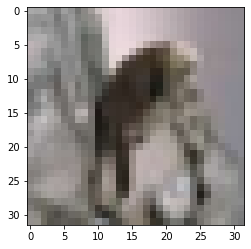

In [66]:
show_example(*dataset[1099])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion of the training set to be used as the validation set. Let's define a function that randomly picks a given fraction of the element indices for creating the validation set. We'll also pass a random seed into the function, so we can recreate the same training/validation split in future runs.

In [67]:
import numpy as np

def split_indices(n, val_pct=0.1, seed=99):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [68]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))
print('Sample validation indices: ', val_indices[:10])

40000 10000
Sample validation indices:  [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


We have randomly shuffled the indices, and selected a small portion ( 20% ) to serve as the validation set. To process our data in small batches, we can now create PyTorch data loaders for each of these using a `SubsetRandomSampler`, which samples elements randomly from a given list of indices, while greating batches of data.

In [69]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size=100

In [70]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size, 
                      sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                    batch_size, 
                    sampler=val_sampler)

We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [71]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1, 2, 0))
        break

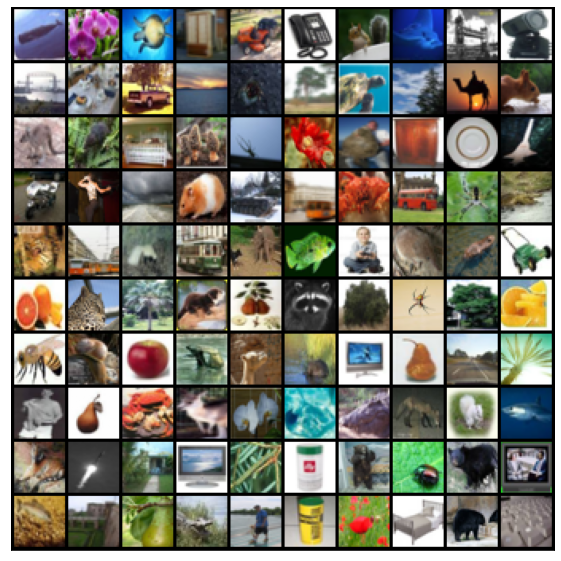

In [72]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

In our [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we defined a deep neural network with fully-connected layers using `nn.Linear`. For this tutorial however, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel âslidesâ over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">

I highly recommend checking out the following articles if want to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

In [74]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

Refer to [Sylvian's post](https://sgugger.github.io/convolution-in-depth.html) for an explanation of `kernel_size`, `stride` and `padding`.    

In [75]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a `n x 1 x 1` feature map (where `n` is the no. of channels), which can be flattened into a vector. We can then add a fully connected layer at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

In [91]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 16 x 16
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 8 x 8

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 4 x 4
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 2 x 2

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 1 x 1,
    
    nn.Flatten(), # output: bs x 16
    nn.Linear(16, 100) # output: bs x 10 
)

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. Check out [Part 3 (logistic regression)](https://jovian.ml/aakashns/03-logistic-regression#C50) for a more detailed discussion on interpeting the outputs, applying softmax and identifying the predicted labels.

In [92]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 100])
out[0]: tensor([ 0.0485, -0.1628,  0.2295,  0.2003,  0.2080,  0.1866,  0.1761, -0.0662,
        -0.1549,  0.1507,  0.0500,  0.0397, -0.1494,  0.0289,  0.2490, -0.0519,
        -0.2227,  0.2567,  0.1604,  0.0989, -0.1741, -0.2049,  0.1326,  0.1659,
        -0.1417,  0.0179, -0.0459,  0.1697, -0.1947,  0.2345,  0.1984, -0.1393,
        -0.1756,  0.0332,  0.0950,  0.0754, -0.0479,  0.1291,  0.0064, -0.1148,
         0.0014,  0.1730,  0.0812, -0.1329, -0.1046, -0.1932,  0.0453,  0.0424,
        -0.1440,  0.1014, -0.2265,  0.1828, -0.1136,  0.0567, -0.1147, -0.1769,
         0.0450,  0.0567,  0.0734, -0.2483,  0.0870, -0.2107, -0.0109, -0.0033,
        -0.1949, -0.1514, -0.1221,  0.0913,  0.1411, -0.1274, -0.2190,  0.1110,
         0.0289,  0.1036,  0.2048,  0.0498,  0.2357, -0.1698,  0.2598,  0.1694,
         0.0678,  0.1548,  0.0585,  0.0947, -0.2459, -0.1753, -0.0072, -0.0926,
         0.2068, -0.1539,  0.0606, 

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [93]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [94]:
device = get_default_device()
device

device(type='cpu')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [95]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(train_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=100, bias=True)
)

## Training the Model

As in the [previous tutorials](https://jovian.ml/aakashns/03-logistic-regression#C71), we can use cross entropy as the loss function and accuracy as the evaluation metric for our model. The training loop is also identical, so we can reuse the `loss_batch`, `evaluate` and `fit` functions from the previous tutorial.

The `loss_batch` function calculates the loss and metric value for a batch of data, and optionally performs gradient descent if an optimizer is provided.

In [96]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Calculate loss
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

The `evaluate` function calculates the overall loss (and a metric, if provided) for the validation set.



In [97]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

The `fit` function (from the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn)) contains the actual training loop: it sets up an optimizer, trains the model using the training set, then evaluates it on the validation set, then logs the losses, metrics etc. and repeats the process for the given number of epochs.

There's one important addition though: We invoke `model.train()` before training the model and `model.eval()` before evaluating it on the validation set. We'll discover what these methods do when we discuss regularization.

In [98]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, 
        opt_fn=None, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    
    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Training
        model.train()
        for xb,yb in train_dl:
            train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Record the loss & metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], train_loss: {:4f}, val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss, 
                          metric.__name__, val_metric))
    return train_losses, val_losses, val_metrics

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit`.

In [99]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

Before we train the model, let's see how it performs on the validation set with the initial set of parameters.

In [104]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3426, Accuracy: 0.2735


The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [102]:
num_epochs = 7
opt_fn = torch.optim.Adam
lr = 0.001

In [103]:
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)
train_losses, val_losses, val_metrics = history

Epoch [1/7], train_loss: 2.6569, val_loss: 2.7741, val_accuracy: 0.1237
Epoch [2/7], train_loss: 2.5961, val_loss: 2.6316, val_accuracy: 0.1728
Epoch [3/7], train_loss: 2.6541, val_loss: 2.5688, val_accuracy: 0.1975
Epoch [4/7], train_loss: 2.5012, val_loss: 2.5156, val_accuracy: 0.2143
Epoch [5/7], train_loss: 2.5140, val_loss: 2.4500, val_accuracy: 0.2422
Epoch [6/7], train_loss: 2.3260, val_loss: 2.4100, val_accuracy: 0.2497
Epoch [7/7], train_loss: 2.2651, val_loss: 2.3426, val_accuracy: 0.2735


In [113]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)
train_losses, val_losses, val_metrics = history

Epoch [1/10], train_loss: 1.9684, val_loss: 1.9914, val_accuracy: 0.3780
Epoch [2/10], train_loss: 2.2721, val_loss: 1.9956, val_accuracy: 0.3740
Epoch [3/10], train_loss: 2.0328, val_loss: 1.9793, val_accuracy: 0.3809


We can also plot the valdation set accuracies to study how the model improves over time.

In [107]:
def plot_metric(metric_values):
    """Plot metric values in a line graph"""
    plt.plot(metric_values, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

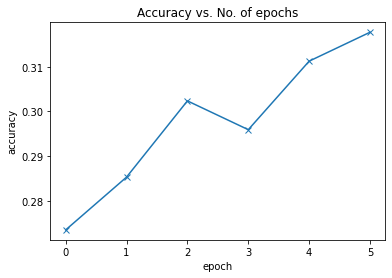

In [108]:
plot_metric([val_acc] + val_metrics)

Our model reaches an accuracy of around 55%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 65% even after training for a long time. This suggests that we might need to use a more powerful model to catpure the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer.

We can also plot the training and validation losses to study the trend.

In [109]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

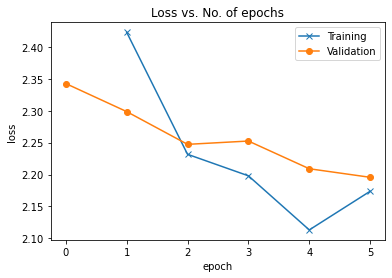

In [110]:
plot_losses([None]+train_losses, [val_loss]+val_losses)

Both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.



In [39]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [40]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: ship


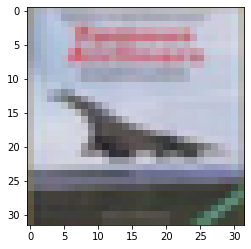

In [41]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: truck


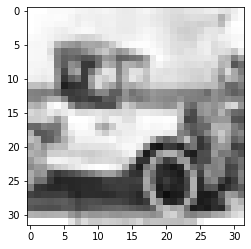

In [42]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


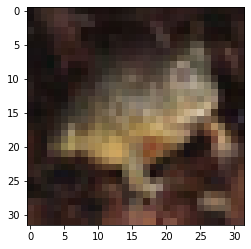

In [43]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set, and record using `jovian`. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [44]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size),device)

test_loss, _, test_acc = evaluate(model, F.cross_entropy, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 1.7000, Accuracy: 0.3753


## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [45]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [46]:
model2 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 16 x 16
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 8 x 8

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 4 x 4
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 2 x 2

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 1 x 1,
    
    nn.Flatten(), # output: bs x 16
    nn.Linear(16, 10) # output: bs x 10 
)

In [47]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [48]:
test_loss, _, test_acc = evaluate(to_device(model2,device), F.cross_entropy, test_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 1.7000, Accuracy: 0.3753


## Summary and Further Reading/Exercises

We've covered a lot of ground in this tutorial. Here's quick recap of the topics:
* Introduction to the CIFAR10 dataset for image classification
* Downloading, extracing and loading an image dataset using `torchvision`
* Show random batches of images in a grid using `torchvision.utils.make_grid`
* Creating a convolutional neural network using with `nn.Conv2d` and `nn.MaxPool2d` layers
* Capturing dataset information, metrics and hyperparameters using the `jovian` library
* Training a convolutional neural network and visualizing the losses and errors
* Understanding overfitting and the strategies for avoiding it (more on this later)
* Generating predictions on single images from the test set
* Saving and loading the model weights, and attaching them to the eperiment snaptshot using `jovian`

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:
* Try chaging the hyperparameters to achieve a higher accuracy within fewer epochs. You use the comparison table on the Jovian.ml project page to compare your experiments.
* Try adding more convolutional layers, or increasing the number of channels in each convolutional layer
* Try using a feedforward neural network and see what's the maximum accuracy you can achieve
* Read about some of the startegies mentioned above for reducing overfitting and achieving better results, and try to implement them by looking into the PyTorch docs.
* Modify this notebook to train a model for a different dataset (e.g. CIFAR100 or ImageNet)

We can further improve our model's accuracy using techniques like data augmentation, batch normalization and dropout.